## MuPe-CV Classification
This notebook explores and studies the performance of MLP and CNN architectures on a very basic Classification Problem on the Fashion MNIST Problem. 

## Dataset: 
Total Images :- 70,000 

Train Images :- 60,000 

Test Images :- 10,000 

Image Size :- 28 X 28 

Different Classes: Classes: 'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot'

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.datasets import mnist
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, Model, load_model
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, Convolution2D, MaxPool2D, MaxPooling2D, ZeroPadding2D, BatchNormalization
from numpy.random import permutation
from keras import optimizers
from tensorflow.keras.optimizers import SGD, Adam
from keras import backend as K
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, plot_confusion_matrix, roc_auc_score, roc_curve

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

import time

## Some necessary functions

In [2]:
def load_data(keras_datasets, first_layer="dense", channels=1, plot_images=False, class_names=[]):
    (x_train, y_train), (x_test, y_test) = keras_datasets.load_data()
    print('Before reshape - X_train.shape:', x_train.shape)
    print('Before reshape - X_test.shape:', x_test.shape)
    height=x_train.shape[1]
    width=x_train.shape[2]        
    # flatten 28*28 images to a 784 vector for each image
    num_pixels = height * width
    
    #plot images
    if plot_images:
        plot_images_with_labels(x_train, y_train, height, width, class_names, 25)
    
    if first_layer == "dense":
        # convert shape of x_train from (60000, 28, 28) to (60000, 784) - 784 columns per row        
        X_train = x_train.reshape((x_train.shape[0], num_pixels)).astype('float32')
        X_test = x_test.reshape((x_test.shape[0], num_pixels)).astype('float32')        
    elif first_layer == "conv2d":
        # Select class 6 images (class 6)
#         x_train = x_train[y_train.flatten() == 6]
        X_train = x_train.reshape((x_train.shape[0], height, width, channels)).astype('float32')
        X_test = x_test.reshape((x_test.shape[0], height, width, channels)).astype('float32')        
        print((x_train.shape[0],) + (height, width, channels))        
        
    print('After reshape - X_train.shape:', X_train.shape)
    print('After reshape - X_test.shape:', X_test.shape)
    print('Before rescaling:', X_train[0])
    #normalize the values between 0 and 1
    X_train = (X_train.astype(np.float32))/255
    X_test = (X_test.astype(np.float32))/255
    print('After rescaling:', X_train[0])
              
    #convert labels to categorical/dummy encoding so that we can use simple "categorical_crossentropy" as loss.
    print('Class label of first image before converting to categorical:', y_train[0])
    # one hot encode outputs
    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)
    num_classes = y_test.shape[1]
    print('Total number of classes:', num_classes)
    print('Class label of first image after converting to categorical:', y_train[0])
              
    return (X_train, y_train, X_test, y_test, height, width)

def plot_images_with_labels(X, y, img_height, img_width, class_names, nb_count=25):
    plt.figure(figsize=(10, 10))
    for i in range(nb_count):
        plt.subplot(np.sqrt(nb_count), np.sqrt(nb_count), i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[i].reshape((img_height,img_width)), cmap=plt.get_cmap('gray'))        
        label_index = int(y[i])
        plt.title(class_names[label_index])
    plt.show()

def train_model(model, X_train, y_train, X_valid=None, y_valid=None, validation_split=0.20, data_aug = False, best_model_name='best_model.h5', epochs=50, batch_size=512,verbose=1):
    er = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=verbose)
    cp = ModelCheckpoint(filepath = best_model_name, save_best_only = True,verbose=verbose)
#     lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_delta=0.0001)
    callbacks = [cp, er]
    
    if not data_aug and X_valid is not None:  
        print('Training without data augmentation...')
        history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,verbose=verbose, callbacks=callbacks, validation_data=(X_valid,y_valid))
        return history
    elif not data_aug and X_valid is None:
        print('Training without data augmentation...')
        history = model.fit(X_train, y_train, batch_size=batch_size,epochs=epochs, verbose=verbose, shuffle=True, callbacks=callbacks, validation_split=validation_split)
        return history
    else:
        print('Training with data augmentation...')
        train_datagen = ImageDataGenerator(shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
        train_set_ae = train_datagen.flow(X_train, y_train, batch_size=batch_size)

        validation_datagen = ImageDataGenerator()
        validation_set_ae = validation_datagen.flow(X_valid, y_valid, batch_size=batch_size)
        
        history = model.fit_generator(train_set_ae,
                                           epochs=epochs,
                                           steps_per_epoch=np.ceil(X_train.shape[0]/batch_size),
                                           verbose=verbose, callbacks=callbacks,
                                           validation_data=(validation_set_ae),
                                           validation_steps=np.ceil(X_valid.shape[0]/batch_size))
        
        return history
    
def plot_loss_and_metrics(history, plot_loss_only= False, metrics=['acc']):
    fig, axes = plt.subplots(nrows=1, ncols=len(metrics)+1, figsize=(20, 4))
    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].set_title('Model Loss')
    axes[0].set_ylabel('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Train', 'Val'], loc='lower right')    
        
    if not plot_loss_only:
        axes[1].plot(history.history['acc'])
        axes[1].plot(history.history['val_acc'])
        axes[1].set_title('Model Accuracy')
        axes[1].set_ylabel('Accuracy')
        axes[1].set_xlabel('Epoch')
        axes[1].legend(['Train', 'Val'], loc='lower right')  
        
        if 'mae' in metrics:
            axes[2].plot(history.history['mae'])
            axes[2].plot(history.history['val_mae'])
            axes[2].set_title('Model Mean Absolute Error')
            axes[2].set_ylabel('Mean Absolute Error')
            axes[2].set_xlabel('Epoch')
            axes[2].legend(['Train', 'Val'], loc='lower right') 
        if 'mse' in metrics:
            axes[3].plot(history.history['mse'])
            axes[3].plot(history.history['val_mse'])
            axes[3].set_title('Model Mean Squared Error')
            axes[3].set_ylabel('Mean Squared Error')
            axes[3].set_xlabel('Epoch')
            axes[3].legend(['Train', 'Val'], loc='lower right')
            
    plt.show()
    
def plot_roc_curve(fpr,tpr): 
  import matplotlib.pyplot as plt
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show()  
    
def load_evaluate_predict(fileName, X_test, y_test, nb_round=0, print_first=1, metrics=['acc']):
    #load best model, evaluate and predict on unseen data    
    best_model = load_model(fileName)
    results = best_model.evaluate(X_test, y_test)    
    print('Test loss = {}'.format(np.round(results[0], 2)))
    print('Test accuracy = {}'.format(np.round(results[1], 2)))
    if len(metrics)>1:
        print('Test ' + metrics[1] + '= {}'.format(np.round(results[2], 2)))
        print('Test ' + metrics[2] + '= {}'.format(np.round(results[3], 2)))

    y_pred_proba = best_model.predict(X_test)
    for i in range(print_first):
        print('')
        print("   Actual:", y_test[i])
        print('Predicted:', np.round(y_pred_proba[i], nb_round))
    
    return best_model, y_pred_proba

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import matplotlib.pyplot as plt
    import itertools
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    
def report_metrics(y_test, y_pred, y_pred_proba, classes, multiclass=False):
    #confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,6))
    plot_confusion_matrix(cnf_matrix, classes=classes, title="Confusion matrix")
    plt.show()

    #classification report
    print('classification report:\n', classification_report(y_test, y_pred))
    
    if not multiclass:
        #calculate the roc auc score
        auc = roc_auc_score(y_test, y_pred_proba)
        print('AUC: %.3f' % auc)
    
        #plot the roc curve
        fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_proba)
        print('ROC curve:\n')
        plot_roc_curve(fpr_keras, tpr_keras)

In [3]:
NUM_CLASSES=10
CLASS_NAMES = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]
EPOCHS=50
BATCH_SIZE=1000
CHANNELS=1
VERBOSE=1
METRICS=['acc']

Before reshape - X_train.shape: (60000, 28, 28)
Before reshape - X_test.shape: (10000, 28, 28)


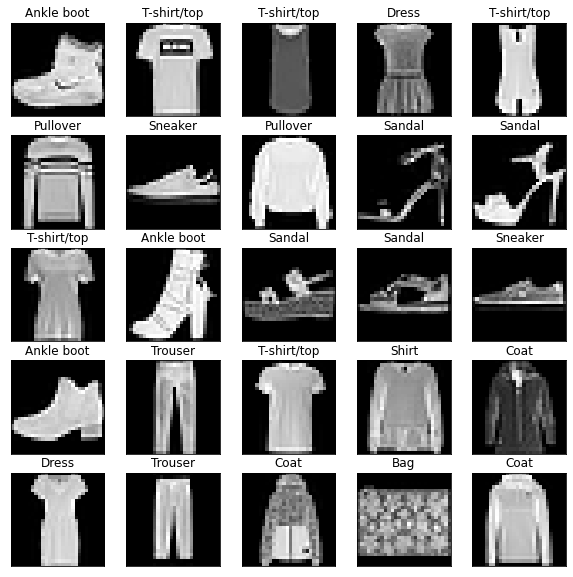

After reshape - X_train.shape: (60000, 784)
After reshape - X_test.shape: (10000, 784)
Before rescaling: [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.
   0.  13.  73.   0.   0.   1.   4.   0.   0.   0.   0.   1.   1.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.   0.
  36. 136. 127.  62.  54.   0.   0.   0.   1.   3.   4.   0.   0.   3.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   6.   0.
 102. 204. 176. 134. 144. 123.  23.   0.   0.   0.   0.  12.  10.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   

In [4]:
X_train, y_train, X_test, y_test, IMG_HEIGHT, IMG_WIDTH = load_data(keras.datasets.fashion_mnist, first_layer="dense", channels=1, plot_images=True, class_names=CLASS_NAMES)

In [5]:
X_train_cnn, y_train_cnn, X_test_cnn, y_test_cnn, IMG_HEIGHT, IMG_WIDTH = load_data(keras.datasets.fashion_mnist, first_layer="conv2d", channels=1, plot_images=False)

Before reshape - X_train.shape: (60000, 28, 28)
Before reshape - X_test.shape: (10000, 28, 28)
(60000, 28, 28, 1)
After reshape - X_train.shape: (60000, 28, 28, 1)
After reshape - X_test.shape: (10000, 28, 28, 1)
Before rescaling: [[[  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]]

 [[  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]]

 [[  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]]

 [[  0.

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=42)
X_train_cnn, X_valid_cnn, y_train_cnn, y_valid_cnn = train_test_split(X_train_cnn, y_train_cnn, test_size=0.20, random_state=42)

## Multi Layer Perceptron(MLP)

A Multi_layer Perceptron Implementations for Classification on Fashion MNIST

Layers: 2 Layers<br>
Parameters: 203,530<br>
Epoch: 200 (but will terminate at no change to the loss)

In [7]:
def build_mlp_model(height, width, nb_classes, metrics):
    #create the multilayer preceptron model with 4 hidden layers
    model = keras.models.Sequential()
#     model.add(keras.layers.Flatten(input_shape=(height, width)))
    model.add(keras.layers.Dense(64, input_dim=(height* width), activation='relu'))
    model.add(keras.layers.Dense(nb_classes, activation='softmax'))
    model.compile(loss = 'categorical_crossentropy',
              optimizer='rmsprop',                           #optimizer=keras.optimizers.SGD(lr=.001),#optimizer='sgd',              
              metrics=metrics)
    return model

model_mlp = build_mlp_model(IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES, METRICS)
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


In [8]:
model_mlp.layers

In [9]:
hidden1 = model_mlp.layers[1]
weights, biases = hidden1.get_weights()
print(weights.shape)
print(biases.shape)

(64, 10)
(10,)


In [10]:
tick=time.process_time()
history_mlp = train_model(model_mlp, X_train, y_train, X_valid=X_valid, y_valid=y_valid, data_aug = False, 
            best_model_name='best_model_mlp.h5', epochs=EPOCHS, batch_size=BATCH_SIZE,verbose=VERBOSE)
tock=time.process_time()
print("-----------------------")
print("time taken", (tock-tick))
print("-----------------------")

Training without data augmentation...
Epoch 1/50
45/48 [===========================>..] - ETA: 0s - loss: 0.9862 - acc: 0.6802
Epoch 1: val_loss improved from inf to 0.71966, saving model to best_model_mlp.h5
48/48 [==============================] - 3s 25ms/step - loss: 0.9688 - acc: 0.6852 - val_loss: 0.7197 - val_acc: 0.7431
Epoch 2/50
47/48 [============================>.] - ETA: 0s - loss: 0.6277 - acc: 0.7835
Epoch 2: val_loss improved from 0.71966 to 0.59026, saving model to best_model_mlp.h5
48/48 [==============================] - 1s 17ms/step - loss: 0.6264 - acc: 0.7838 - val_loss: 0.5903 - val_acc: 0.7894
Epoch 3/50
47/48 [============================>.] - ETA: 0s - loss: 0.5490 - acc: 0.8099
Epoch 3: val_loss improved from 0.59026 to 0.53357, saving model to best_model_mlp.h5
48/48 [==============================] - 1s 19ms/step - loss: 0.5482 - acc: 0.8100 - val_loss: 0.5336 - val_acc: 0.8106
Epoch 4/50
45/48 [===========================>..] - ETA: 0s - loss: 0.5077 - acc:

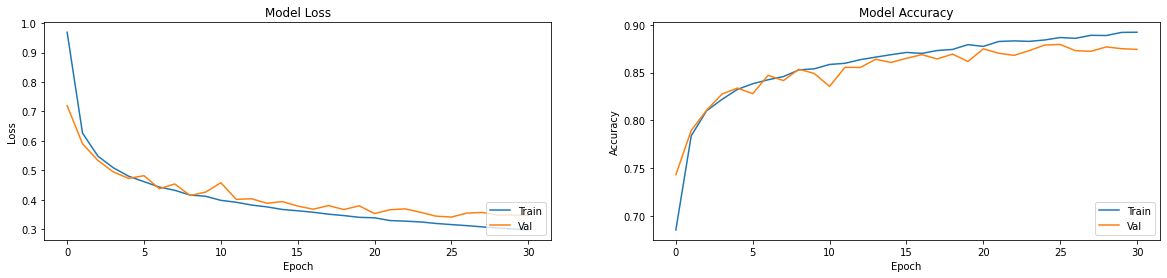

313/313 [==============================] - 1s 1ms/step - loss: 0.3663 - acc: 0.8686
Test loss = 0.37
Test accuracy = 0.87

   Actual: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Predicted: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[1.7861385e-05 2.5730891e-09 5.7379561e-06 1.4932265e-06 1.7428585e-05
 6.9232143e-02 2.6182774e-05 8.2796119e-02 2.1377320e-03 8.4576529e-01]
(10,)
[9 2 1 ... 8 1 5]


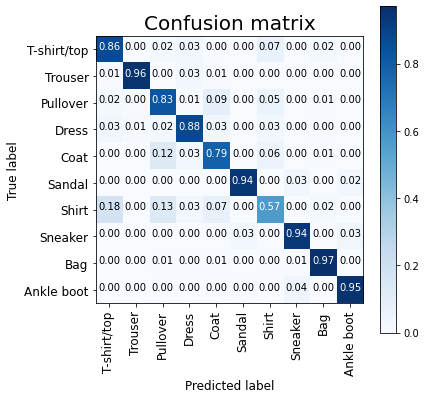

classification report:
               precision    recall  f1-score   support

           0       0.78      0.86      0.82      1000
           1       0.98      0.96      0.97      1000
           2       0.74      0.83      0.78      1000
           3       0.87      0.88      0.87      1000
           4       0.79      0.79      0.79      1000
           5       0.96      0.94      0.95      1000
           6       0.74      0.57      0.64      1000
           7       0.92      0.94      0.93      1000
           8       0.94      0.97      0.96      1000
           9       0.94      0.95      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [11]:
# print the loss and accuracy
plot_loss_and_metrics(history_mlp)
_, y_pred_proba_mlp = load_evaluate_predict('best_model_mlp.h5', X_test, y_test, nb_round=0, print_first=1, metrics=METRICS)

print(y_pred_proba_mlp[0])
print(y_pred_proba_mlp[0].shape)
## Get most likely class
y_pred_mlp = np.argmax(y_pred_proba_mlp, axis=1)
print(y_pred_mlp)

#Confusion Matrix, Classification report, ROC curve
report_metrics(np.argmax(y_test, axis=1), y_pred_mlp, y_pred_proba_mlp, CLASS_NAMES, multiclass=True)

## Convolutional Neural Network

A CNN Implementation for Image Classification on the Fashion MNIST Dataset.

Layers: 6<br>
Parameters: 694,090<br>
Epochs: 200 (will terminate early in case of no change to the loss)

In [12]:
def create_simple_conv_model(image_height=IMG_HEIGHT, image_width=IMG_WIDTH, channels=CHANNELS, nb_classes=NUM_CLASSES, metrics=METRICS, optimizer='adam'):    
    # number of convolutional filters to use
    nb_filters = 32   
    # convolution kernel size
    nb_conv = 3
     # size of pooling area for max pooling
    nb_pool = 2
    model = Sequential()
    model.add(Conv2D(filters=nb_filters, kernel_size=(nb_conv,nb_conv), strides=(1, 1), activation='relu', input_shape=(image_height, image_width, channels)))  
    model.add(BatchNormalization())    
    model.add(MaxPool2D(pool_size=(nb_pool,nb_pool)))   
#     model.add(Dropout(0.5))   

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))    
#     model.add(Dropout(0.5))
    
    model.add(Dense(nb_classes, activation='softmax'))   
        
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=metrics)
    return model

model_cnn = create_simple_conv_model(IMG_HEIGHT, IMG_WIDTH, CHANNELS, NUM_CLASSES, METRICS)
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               692352    
                                                                 
 dense_3 (Dense)             (None, 10)               

In [13]:
tick=time.process_time()
history_cnn = train_model(model_cnn, X_train_cnn, y_train_cnn, X_valid=X_valid_cnn, y_valid=y_valid_cnn, data_aug = False, 
            best_model_name='best_model_cnn.h5', epochs=EPOCHS, batch_size=BATCH_SIZE,verbose=VERBOSE)
tock=time.process_time()
print("-----------------------")
print("time taken", (tock-tick))
print("-----------------------")

Training without data augmentation...
Epoch 1/50
48/48 [==============================] - ETA: 0s - loss: 0.5443 - acc: 0.8114
Epoch 1: val_loss improved from inf to 1.86188, saving model to best_model_cnn.h5
48/48 [==============================] - 28s 568ms/step - loss: 0.5443 - acc: 0.8114 - val_loss: 1.8619 - val_acc: 0.8269
Epoch 2/50
48/48 [==============================] - ETA: 0s - loss: 0.2772 - acc: 0.9003
Epoch 2: val_loss improved from 1.86188 to 1.68526, saving model to best_model_cnn.h5
48/48 [==============================] - 27s 567ms/step - loss: 0.2772 - acc: 0.9003 - val_loss: 1.6853 - val_acc: 0.8443
Epoch 3/50
48/48 [==============================] - ETA: 0s - loss: 0.2191 - acc: 0.9206
Epoch 3: val_loss improved from 1.68526 to 1.46179, saving model to best_model_cnn.h5
48/48 [==============================] - 29s 597ms/step - loss: 0.2191 - acc: 0.9206 - val_loss: 1.4618 - val_acc: 0.8694
Epoch 4/50
48/48 [==============================] - ETA: 0s - loss: 0.1833 

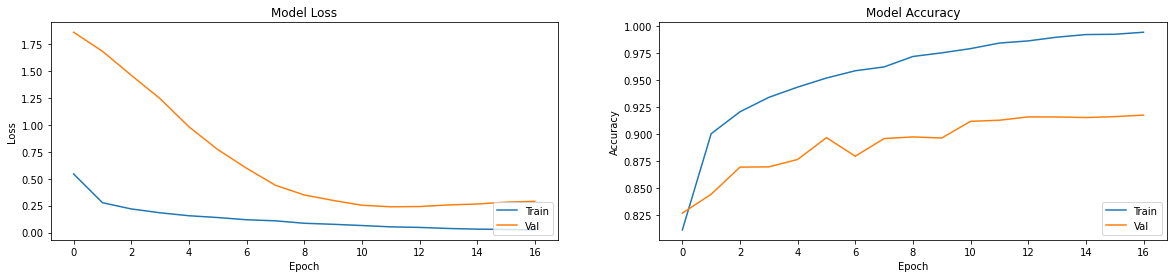

313/313 [==============================] - 3s 8ms/step - loss: 0.2615 - acc: 0.9042
Test loss = 0.26
Test accuracy = 0.9

   Actual: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Predicted: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[3.7379593e-06 1.2152378e-06 1.6748170e-05 4.2976244e-06 1.2130380e-06
 7.6440730e-05 2.8049485e-07 6.6949066e-04 1.4523391e-05 9.9921203e-01]
(10,)
[9 2 1 ... 8 1 5]


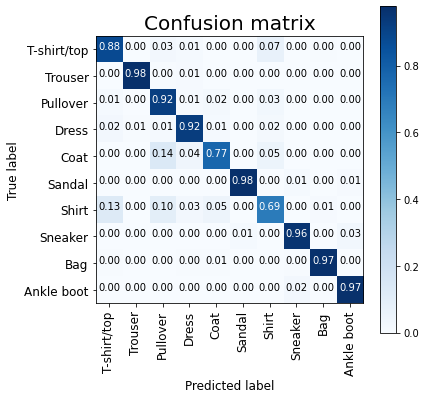

classification report:
               precision    recall  f1-score   support

           0       0.84      0.88      0.86      1000
           1       0.99      0.98      0.98      1000
           2       0.77      0.92      0.84      1000
           3       0.90      0.92      0.91      1000
           4       0.89      0.77      0.83      1000
           5       0.98      0.98      0.98      1000
           6       0.80      0.69      0.74      1000
           7       0.96      0.96      0.96      1000
           8       0.98      0.97      0.97      1000
           9       0.96      0.97      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.91      0.90      0.90     10000
weighted avg       0.91      0.90      0.90     10000



In [14]:
# print the loss and accuracy
plot_loss_and_metrics(history_cnn)
_, y_pred_proba_cnn=  load_evaluate_predict('best_model_cnn.h5', X_test_cnn, y_test, nb_round=0, print_first=1, metrics=METRICS)

print(y_pred_proba_cnn[0])
print(y_pred_proba_cnn[0].shape)
## Get most likely class
y_pred_cnn = np.argmax(y_pred_proba_cnn, axis=1)
print(y_pred_cnn)

#Confusion Matrix, Classification report, ROC curve
report_metrics(np.argmax(y_test, axis=1), y_pred_cnn, y_pred_proba_cnn, CLASS_NAMES, multiclass=True)

## References
* https://victorzhou.com/blog/keras-neural-network-tutorial/
* https://www.kaggle.com/gpreda/cnn-with-tensorflow-keras-for-fashion-mnist
* https://www.kaggle.com/yufengg/fashion-mnist
* https://www.kaggle.com/ankurshukla03/cnn-for-fashion-mnist
* https://machinelearningmastery.com/implement-perceptron-algorithm-scratch-python/
* https://www.kaggle.com/jyotiprasadpal/deep-learning-singlelayer-perceptron?scriptVersionId=31873120